# Exercise Chapter 11_ex 
Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, optimize
import statsmodels.formula.api as smf
import lifelines
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import mistat
from mistat import acceptanceSampling

# Exercise 10

In [3]:
np.random.seed(1)

N=75; lambda_=0.6; k0=15; gamma=0.95; Ns=1000

results = []
for p in (0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8):
  r = acceptanceSampling.simulateOAB(N, p, lambda_, k0, gamma, Ns)
  results.append({
      'p': p,
      'Mgamma_mean': r.mgamma.mean,
      'Mgamma_std': r.mgamma.std,
      'Reward_mean': r.reward.mean,
      'Reward_std': r.reward.std,
  })
pd.DataFrame(results)

,p,Mgamma_mean,Mgamma_std,Reward_mean,Reward_std
0,0.40,22.639,11.931080,40.4016,0.904609
1,0.45,31.382,19.866758,40.3588,1.222515
2,0.50,42.608,24.492822,40.8492,2.075587
3,0.55,57.779,23.582794,42.6366,3.416241
4,0.60,66.750,18.822526,45.4380,4.143640
5,0.65,71.662,12.721154,49.1878,4.508895
6,0.70,73.924,7.576953,52.9706,4.282127
7,0.75,74.762,3.755710,57.0788,3.971714
8,0.80,74.945,1.738383,60.7050,3.518803


# Exercise 11

In [4]:
result = acceptanceSampling.optimalOAB(75, 0.6)
print(f'Case (75, 0.6): {result.max_reward:.3f}')

Case (75, 0.6): 62.447


# Exercise 12

In [5]:
def TAB(N, k, Xk):
    # case: no reward for the first k // 2 trials - switch
    if Xk == 0:
        # calculate posterior based on no successes in k//2 trials
        m = k//2
        p_post = (1 + 0) / (1 + 1 + m) 
        return acceptanceSampling.optimalOAB(N - m, p_post).max_reward

    # calculate posterior based on Xk successes in k trials
    p_post = (1 + Xk) / (1 + 1 + k) 
    # case: only successes in trials stay in arm A
    if Xk == k: 
        return k + (N-k) * p_post
    # switch to arm B and use posterior propability for 
    # optimal OAB strategy
    return Xk + acceptanceSampling.optimalOAB(N-k, p_post).max_reward

In [6]:
pd.DataFrame({
    'X10': list(range(0, 11)),
    'Expected reward': [TAB(40, 10, Xk) for Xk in range(0, 11)],
})

,X10,Expected reward
0,0,26.331820
1,1,23.597716
2,2,24.782446
3,3,26.078104
4,4,27.487403
5,5,29.020577
6,6,30.662946
7,7,32.475568
8,8,34.380689
9,9,36.500000


# Exercise 19

In [7]:
def modelGoelOkumoto(t, a, b):
    return a * (1 - np.exp(-b * t))

def modelMusaOkumoto(t, phi, lam):
    return (1/phi) * np.log(lam*phi* t + 1)

def modelYamada(t, a, b):
    return a * (1 - (1+b*t)*np.exp(-b*t))

def modelInflectedSshaped(t, a, b, c):
    return a * (1 - np.exp(-b * t)) / (1 + c * np.exp(-b * t))

In [8]:
def optimizeModelFit(model, data, x, y):
    fit = optimize.curve_fit(model, data[x], data[y], method='lm')
    popt = fit[0]
    # add the fit curve to the data
    data[model.__name__] = [model(t, *popt) for t in data[x]]
    return popt
data = mistat.load_data('FAILURE_J2')
optimizeModelFit(modelGoelOkumoto, data, 'T', 'CFC') 
optimizeModelFit(modelMusaOkumoto, data, 'T', 'CFC') 
optimizeModelFit(modelYamada, data, 'T', 'CFC') 
optimizeModelFit(modelInflectedSshaped, data, 'T', 'CFC') 

array([2.26933527e+02, 5.40121092e-02, 5.96246327e+01])

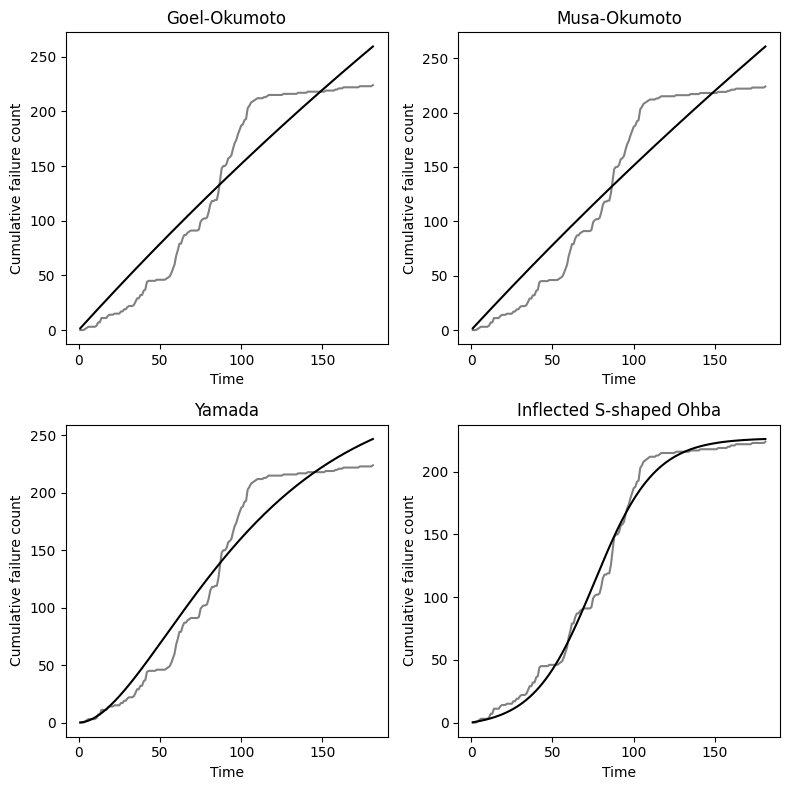

In [9]:
def plotModel(data, model, label, ax):
    ax.plot(data['T'], data['CFC'], color='grey')
    ax.plot(data['T'], data[model], color='black')
    ax.set_title(label)
    ax.set_xlabel('Time')
    ax.set_ylabel('Cumulative failure count')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 8])
plotModel(data, 'modelGoelOkumoto', 'Goel-Okumoto', axes[0,0])
plotModel(data, 'modelMusaOkumoto', 'Musa-Okumoto', axes[0,1])
plotModel(data, 'modelYamada', 'Yamada', axes[1,0])
plotModel(data, 'modelInflectedSshaped', 'Inflected S-shaped Ohba', axes[1,1])
plt.tight_layout()
plt.show()

# Exercise 20

In [10]:
def optimizeModelFit(model, data, x, y, subset):
    # create the subset
    subsetX = data[x][:subset]
    subsetY = data[y][:subset]
    # fit curve to subset - a increase of maxfev is required
    fit = optimize.curve_fit(model, subsetX, subsetY, 
                             method='lm', maxfev=2000)
    popt = fit[0]
    data[f'{model.__name__} {subset}'] = [model(t, *popt) for t in data[x]]
    return popt
for subset in [25, 50, 75, 100, 125, 150]:
    optimizeModelFit(modelGoelOkumoto, data, 'T', 'CFC', subset) 
    optimizeModelFit(modelInflectedSshaped, data, 'T', 'CFC', subset)

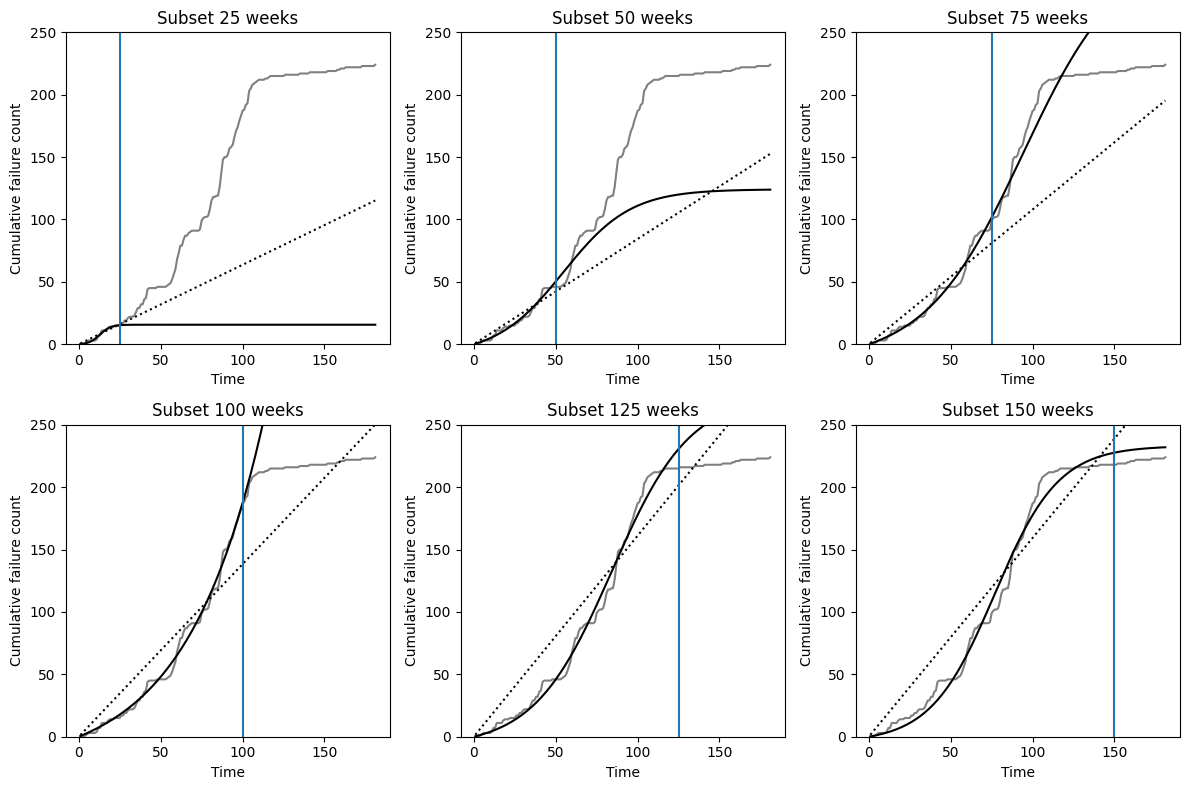

In [11]:
def plotModel(data, subset, ax):
    ax.plot(data['T'], data['CFC'], color='grey')
    ax.plot(data['T'], data[f'modelGoelOkumoto {subset}'], color='black', linestyle=':')
    ax.plot(data['T'], data[f'modelInflectedSshaped {subset}'], color='black')
    ax.set_title(f'Subset {subset} weeks')
    ax.set_xlabel('Time')
    ax.set_ylabel('Cumulative failure count')
    ax.set_ylim(0, 250)
    ax.axvline(subset)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[12, 8])
plotModel(data, 25, axes[0, 0])
plotModel(data, 50, axes[0, 1])
plotModel(data, 75, axes[0, 2])
plotModel(data, 100, axes[1, 0])
plotModel(data, 125, axes[1, 1])
plotModel(data, 150, axes[1, 2])
plt.tight_layout()
plt.show()

# Exercise 21

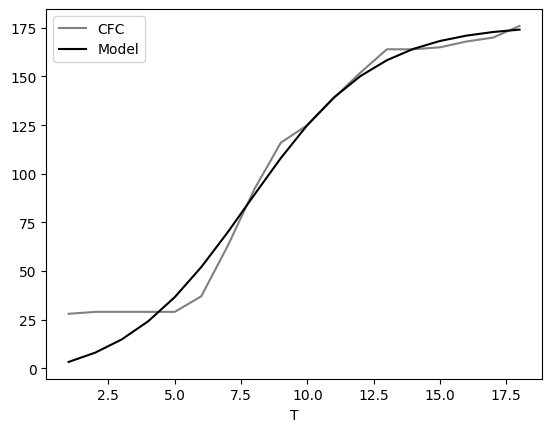

In [12]:
data = mistat.load_data('FAILURE_DS2')
fit = optimize.curve_fit(modelInflectedSshaped, data['T'], data['CFC'])
popt = fit[0]

# add the fit curve to the data and visualize
data['Model'] = [modelInflectedSshaped(t, *popt) for t in data['T']]

ax = data.plot(x='T', y='CFC', color='grey')
data.plot(x='T', y='Model', color='black', ax=ax)
plt.show()

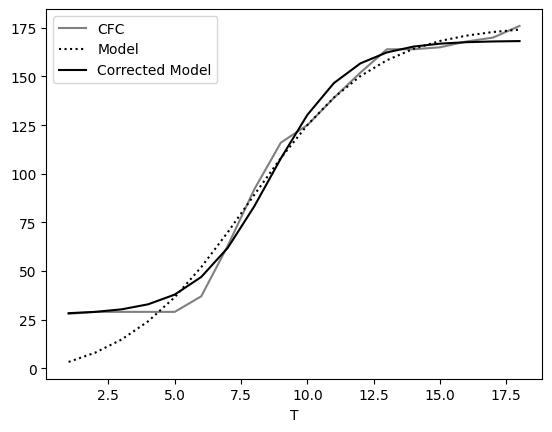

In [13]:
initial = data['CFC'][0]
def correctedModel(t, a, b, c):
    return modelInflectedSshaped(t, a, b, c) + initial

fit = optimize.curve_fit(correctedModel, data['T'], data['CFC'])
popt = fit[0]
# add the fit curve to the data and visualize
data['Corrected Model'] = [correctedModel(t, *popt) for t in data['T']]

ax = data.plot(x='T', y='CFC', color='grey')
data.plot(x='T', y='Model', color='black', ax=ax, linestyle=':')
data.plot(x='T', y='Corrected Model', color='black', ax=ax)
plt.show()